In [4]:
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/indian-buffet-process/data/new_annotations.h5ad")
adata = adata[adata.obs["Cell.Type"].eq("Fibroblast")]

In [18]:
import torch
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("CUDA Enabled")

def setup_torch_data(adata):
    X = torch.tensor(adata[:, (adata.X > 0).mean(axis=0) > 0.05].X.todense())
    size_factor = torch.tensor(np.log((adata.X.sum(axis=1) / adata.X.sum(axis=1).mean())))
    return X, size_factor

X, size_factor = setup_torch_data(adata)

X = X.to(device)
size_factor = size_factor.to(device)

In [19]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTraceMeanField_ELBO, JitTrace_ELBO
from pyro.optim import ClippedAdam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

def model(X, K_tensor, size_factor, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape

    alpha_param = pyro.param(
        "alpha",
        dist.Gamma(torch.full((), alpha, device=device, dtype=dtype),
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )
    beta_param = pyro.param(
        "beta",
        dist.Gamma(alpha_param,
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )

    with pyro.plate("ibp_features", K):
        v = pyro.sample("v", dist.Beta(alpha_param, beta_param))  # [K]

    pi = torch.cumprod(v, dim=0)

    W = pyro.sample(
        "W",
        dist.Normal(torch.full((), 0.0, device=device, dtype=dtype),
                    torch.full((), 1.0, device=device, dtype=dtype))
        .expand([K, D]).to_event(2)
    )

    r = pyro.sample(
        "r",
        dist.Gamma(torch.full((), 2.0, device=device, dtype=dtype),
                   torch.full((), 1.0, device=device, dtype=dtype))
        .expand([D]).to_event(1)
    )
    r = r.unsqueeze(0)  # [1, D]

    with pyro.plate("observations", N):
        z = pyro.sample("Z", dist.Bernoulli(pi).to_event(1))  # [N, K]
        logits = z @ W + size_factor  # [N, D]
        pyro.sample("X", dist.NegativeBinomial(total_count=r, logits=logits).to_event(1), obs=X)


def guide(X, K_tensor, size_factor):
    K = int(K_tensor.item())
    N, D = X.shape

    with pyro.plate("ibp_features", K):
        qv_alpha = pyro.param("qv_alpha", torch.ones(K, device=device, dtype=dtype),
                              constraint=dist.constraints.greater_than(1e-2))
        qv_beta = pyro.param("qv_beta", torch.ones(K, device=device, dtype=dtype),
                             constraint=dist.constraints.greater_than(1e-2))
        pyro.sample("v", dist.Beta(qv_alpha, qv_beta))

    with pyro.plate("observations", N):
        qz_logits = pyro.param("qz_logits", (torch.randn(N, K, device=device, dtype=dtype) / 100 - 2.0))
        pyro.sample("Z", dist.RelaxedBernoulliStraightThrough(
            temperature=torch.full((), 0.5, device=device, dtype=dtype),
            logits=qz_logits
        ).to_event(1))

    qW_loc = pyro.param("qW_loc", torch.randn(K, D, device=device, dtype=dtype))
    qW_scale = pyro.param("qW_scale", torch.ones(K, D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    pyro.sample("W", dist.Normal(qW_loc, qW_scale).to_event(2))

    qr_alpha = pyro.param("qr_alpha", torch.ones(D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    qr_beta = pyro.param("qr_beta", torch.ones(D, device=device, dtype=dtype),
                         constraint=dist.constraints.positive)
    pyro.sample("r", dist.Gamma(qr_alpha, qr_beta).to_event(1))


In [20]:
# Example training loop
pyro.clear_param_store()

X = X.to(device=device, dtype=dtype)
size_factor = size_factor.to(device=device, dtype=dtype)
K = torch.tensor(40, device=device)  # or whatever value, as a tensor


optimizer = ClippedAdam({"lr": 0.01})
elbo = JitTrace_ELBO() # Real Fn Fast
# elbo = JitTraceMeanField_ELBO() # Testing
svi = SVI(model, guide, optimizer, loss=elbo)

import wandb
wandb.init(project="ibp-nb-model-fibroblast", name="kanna-chameleon-fibroblast-1", config={
    "latent_dim_K": K,
    "learning_rate": 1e-2,
    "elbo": "JitTrace_ELBO",
})

wandb: Currently logged in as: jhaberbe (kibr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [21]:
for step in range(100_000):
    loss = svi.step(X, K, size_factor)
    if step % 1 == 0:
        mean_logits = pyro.get_param_store()["qz_logits"].mean().item()
        percentage_logits_above_0 = (pyro.get_param_store()["qz_logits"] > 0).float().mean().item()
        
        wandb.log({
            "step": step,
            "loss": loss,
            "mean_logits": mean_logits,
            "percentage_logits_above_0": percentage_logits_above_0
        })
        
        print(f"[Step {step}] Loss: {loss:.2e}", mean_logits, percentage_logits_above_0)

/tmp/ipykernel_78832/1422386189.py:54: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  K = int(K_tensor.item())
/tmp/ipykernel_78832/1422386189.py:11: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  K = int(K_tensor.item())


[Step 0] Loss: 6.82e+08 -1.9974737167358398 0.0
[Step 1] Loss: 6.61e+08 -1.9959447383880615 0.0
[Step 2] Loss: 6.51e+08 -1.9945870637893677 0.0
[Step 3] Loss: 6.41e+08 -1.9931405782699585 0.0
[Step 4] Loss: 6.47e+08 -1.9917863607406616 0.0
[Step 5] Loss: 6.27e+08 -1.9901727437973022 0.0
[Step 6] Loss: 6.22e+08 -1.9884098768234253 0.0
[Step 7] Loss: 6.18e+08 -1.9864898920059204 0.0
[Step 8] Loss: 6.05e+08 -1.9843446016311646 0.0
[Step 9] Loss: 5.97e+08 -1.9819815158843994 0.0
[Step 10] Loss: 5.87e+08 -1.979382872581482 0.0
[Step 11] Loss: 5.78e+08 -1.976556658744812 0.0
[Step 12] Loss: 5.77e+08 -1.9735279083251953 0.0
[Step 13] Loss: 5.66e+08 -1.9703789949417114 0.0
[Step 14] Loss: 5.60e+08 -1.9670429229736328 0.0
[Step 15] Loss: 5.54e+08 -1.963517665863037 0.0
[Step 16] Loss: 5.53e+08 -1.9598321914672852 0.0
[Step 17] Loss: 5.41e+08 -1.9559942483901978 0.0
[Step 18] Loss: 5.36e+08 -1.9519715309143066 0.0
[Step 19] Loss: 5.38e+08 -1.9478353261947632 0.0
[Step 20] Loss: 5.27e+08 -1.94355

KeyboardInterrupt: 

In [22]:
pyro.get_param_store().save("/home/jhaberbe/Projects/indian-buffet-process/output/fibroblast-latent-features-05-08-2025.pt")
output = pyro.get_param_store()

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7a35f9364590>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7a34c0515fd0, raw_cell="pyro.get_param_store().save("/home/jhaberbe/Projec.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/indian-buffet-process/notebook/scratch.ipynb#W6sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7a35f9364590>> (for post_run_cell), with arguments args (<ExecutionResult object at 7a34c0515be0, execution_count=22 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7a34c0515fd0, raw_cell="pyro.get_param_store().save("/home/jhaberbe/Projec.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/indian-buffet-process/notebook/scratch.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

# Outcome

In [5]:
import torch
import numpy as np
output = torch.load(open("../output/fibroblast-latent-features-05-08-2025.pt", "rb"), weights_only=False)["params"]

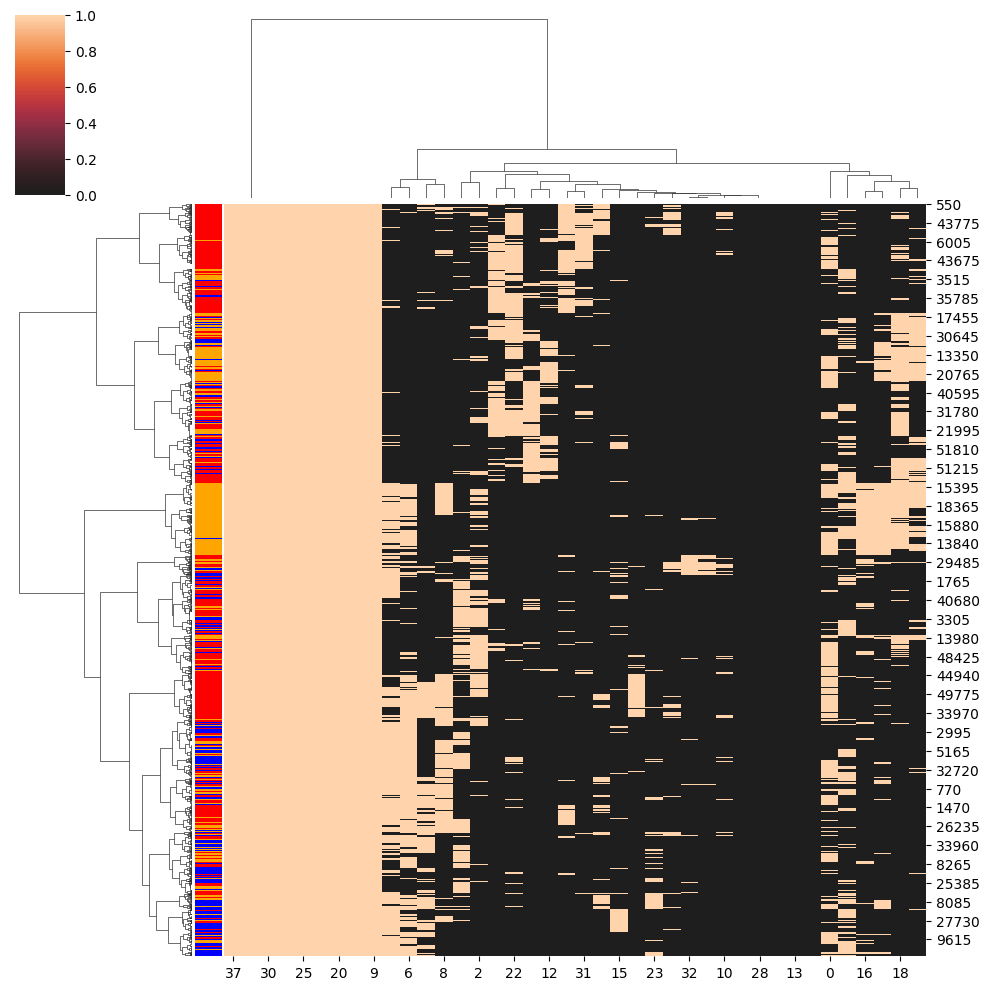

In [6]:
import pandas as pd
import seaborn as sns

sns.clustermap(
    pd.DataFrame((output["qz_logits"]).cpu().detach().numpy()).gt(0).iloc[::5],
    method="ward",
    metric="cityblock",
    center=0,
    row_colors=adata.obs["cogdx"].iloc[::5].replace({
    1: "blue",
    2: "orange",
    4: "red"
}).tolist()
)

In [7]:
latent_features = pd.DataFrame((output["qz_logits"]).cpu().detach().numpy()).gt(0)
latent_features["specimen"] = adata.obs["orig.ident"].tolist()

latent_features = latent_features.groupby(["specimen"]).sum().div(adata.obs["orig.ident"].value_counts(), axis=0)
latent_features["cog"] = [x.split("_")[1][0] for x in latent_features.index]

In [ ]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
from itertools import combinations

alpha = 0.1
groups = ["C", "M", "A"]
eps = 1e-3
n_samples = 5_000  # reduce if performance is an issue

def run_pymc_beta_model(feature_vals, group_labels):
    group_idx = pd.Categorical(group_labels, categories=groups).codes
    clipped_vals = np.clip(feature_vals, eps, 1 - eps)

    with pm.Model() as model:
        a = pm.Exponential('a', 1.0, shape=len(groups))
        b = pm.Exponential('b', 1.0, shape=len(groups))
        
        obs = pm.Beta('obs', alpha=a[group_idx], beta=b[group_idx],
                      observed=clipped_vals)
        
        trace = pm.sample(n_samples, tune=1000, chains=4, progressbar=True, target_accept=0.9)
        
    return trace

def credible_difference(trace, param, group1, group2, threshold=0.95):
    # Extract posterior samples for group-specific parameter (e.g. alpha[0], alpha[1])
    samples1 = trace.posterior[param].sel(a_dim_0=groups.index(group1)).values.flatten()
    samples2 = trace.posterior[param].sel(a_dim_0=groups.index(group2)).values.flatten()
    
    diff = samples1 - samples2
    prob_diff = np.mean(diff > 0)  # P(group1 > group2)

    # Two-sided
    prob = max(prob_diff, 1 - prob_diff)
    return prob > threshold, prob

# ---- Main Loop ----
for feature in latent_features.columns:
    if feature == "cog":
        continue
    if latent_features[feature].mean() == 1 or latent_features[feature].mean() == 0:
        continue

    df = latent_features[[feature, "cog"]].dropna()
    if df["cog"].nunique() < 2:
        continue

    print(f"\n🔎 Running Bayesian beta model for '{feature}'")
    trace = run_pymc_beta_model(df[feature].values, df["cog"])

    # Pairwise group comparisons based on posterior of means
    for g1, g2 in combinations(groups, 2):
        # Compute posterior means from alpha and beta
        a1 = trace.posterior['a'].sel(a_dim_0=groups.index(g1)).values.flatten()
        b1 = trace.posterior['b'].sel(b_dim_0=groups.index(g1)).values.flatten()
        a2 = trace.posterior['a'].sel(a_dim_0=groups.index(g2)).values.flatten()
        b2 = trace.posterior['b'].sel(b_dim_0=groups.index(g2)).values.flatten()

        mean1 = a1 / (a1 + b1)
        mean2 = a2 / (a2 + b2)

        prob_diff = np.mean(mean1 > mean2)
        prob = max(prob_diff, 1 - prob_diff)

        if prob > 1-alpha:
            direction = ">" if prob_diff > 0.5 else "<"
            print(f"  ➤ {g1} {direction} {g2} with {prob:.2%} certainty based on mean")




🔎 Running Bayesian beta model for '0'


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.
Initializing NUTS using jitter+adapt_diag...



🔎 Running Bayesian beta model for '1'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.
Initializing NUTS using jitter+adapt_diag...



🔎 Running Bayesian beta model for '2'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Initializing NUTS using jitter+adapt_diag...



🔎 Running Bayesian beta model for '3'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Initializing NUTS using jitter+adapt_diag...



🔎 Running Bayesian beta model for '4'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

<Axes: xlabel='variable', ylabel='value'>

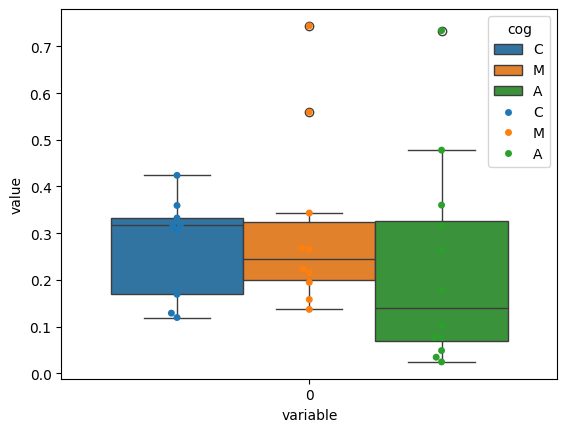

In [9]:
import seaborn as sns
sns.boxplot(
    latent_features.reset_index().melt(id_vars=["index", "cog"]).query("variable == 0"),
    x="variable",
    y="value",
    hue="cog",
    hue_order=list("CMA")
)
sns.swarmplot(
    latent_features.reset_index().melt(id_vars=["index", "cog"]).query("variable == 0"),
    x="variable",
    y="value",
    hue="cog",
    hue_order=list("CMA"),
    dodge=True,
    edgecolor="k"
)

In [203]:
import pandas as pd
# table = pd.DataFrame(
#     output["qW_loc"].cpu().detach().numpy(),
#     columns=adata[:, (adata.X > 0).mean(axis=0) > 0.20].var_names
# )
table.T.sort_values(by=0, ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
CFAP299,0.733924,-0.251925,-0.022325,0.160344,-0.357949,-0.107771,0.149203,-0.135254,-0.008460,-0.177163,...,0.346968,-0.011421,-0.057109,-0.047215,0.019728,-0.058629,-0.004195,-0.060999,-0.023556,-0.039188
ADGB,0.698488,-0.185380,-0.019487,0.185798,-0.260759,-0.052299,0.116382,-0.122803,-0.240621,-0.168350,...,0.320546,0.023224,0.026378,0.016334,0.105779,0.008233,0.027376,-0.009217,0.010621,0.044503
CCDC39,0.649026,-0.182791,-0.081797,0.159209,-0.242206,-0.088904,-0.036443,-0.066613,-0.318051,-0.148487,...,0.293725,0.007081,0.025985,0.025395,0.140279,0.053587,0.024510,0.039011,0.018394,0.023799
AC004052.1,0.639450,0.071180,0.132887,0.338614,-0.023272,-0.034597,0.132795,0.071914,0.233936,-0.090407,...,0.184159,0.029299,0.013562,0.044384,0.094927,0.024299,0.034760,0.007745,0.042412,0.012586
ZBBX,0.568728,-0.135923,-0.149642,0.139312,-0.194267,-0.079800,-0.001673,-0.086397,-0.256112,-0.160702,...,0.154189,-0.037447,0.021616,-0.019575,-0.025715,0.021000,-0.015120,0.002147,-0.016100,-0.046115
DNAH9,0.558949,-0.227744,-0.026757,0.121207,-0.276893,-0.101884,-0.185346,-0.012101,0.030717,-0.103194,...,0.207914,0.056637,0.018678,0.052211,0.046890,0.032089,0.037093,0.040458,0.045086,0.031916
TMEM232,0.558108,-0.021403,0.036090,0.238477,-0.068046,0.003946,0.154410,0.055015,0.137294,0.001546,...,0.229600,0.015876,0.024282,0.021419,0.081901,0.017863,0.031159,0.007766,0.042507,0.042965
CDHR3,0.545760,-0.164070,0.062686,0.233092,-0.204566,0.097469,0.188550,-0.127130,-0.002024,-0.126927,...,0.133586,-0.024292,-0.015254,-0.004111,-0.015315,-0.013779,-0.008591,-0.019780,-0.002088,-0.006622
VWA3B,0.536329,-0.154113,-0.032929,0.168876,-0.219954,-0.012911,-0.007366,-0.104330,-0.303352,-0.140035,...,0.176029,-0.001154,-0.005806,-0.032805,0.070136,-0.023494,-0.020713,-0.034955,-0.029760,-0.018205
TEKT1,0.534885,-0.224715,-0.103550,0.062696,-0.228693,0.079121,-0.097192,-0.171876,-0.234097,-0.280693,...,0.129170,-0.025661,-0.035391,-0.038099,-0.021060,0.011553,-0.018746,-0.025949,-0.008933,-0.006804
